# Optimizacion del k de kNN con weights distance_pow


## Buildear

In [ ]:
!cd .. && ./build.sh

## Carga de datos

In [ ]:
%load_ext autoreload
%autoreload 2
import pandas as pd

df_train = pd.read_csv("../data/train.csv")
df_train.info()

In [ ]:
# Uso values para mandar todo a arrays de numpy
X = df_train[df_train.columns[1:]].values
y = df_train["label"].values.reshape(-1, 1)

X.shape, y.shape

### Optimizacion de k con simmulated annealing

In [ ]:
import metnum

import numpy.random as rn
import numpy as np

from scoring import cross_validation as cv
from scoring import metrics

k_range = (1, 100)
T = 100

# Seed del random para reproducibilidad del experimento
rn.seed(2020)

## Funciones parametro de simm ann

def clip_k(k):
    """Le pasas el state y lo pone en el rango valido"""
    a, b = k_range
    
    return max(a,min(b,int(k)))

def random_start():
    """Elige un state start aleatorio"""
    a, b = k_range
    rnd_k = a + (b - a) * rn.random_sample()
    return clip_k(rnd_k)

def random_neighbour(actual_k, fraction=0.0):
    """
    Varia un poco el estado actual para moverse en el espacio
    y probar una solucion distinta.
    """
    a, b = k_range
    new_k = actual_k
    
    MAX_ATTEMPTS = 10
    attempts = 0
    while new_k == actual_k and fraction != 1.0 and attempts < 10: # add circuit breaker at 10 attempts
        attempts += 1
        
        a, b = k_range
    
        # https://numpy.org/doc/1.18/reference/random/generated/numpy.random.random_sample.html
        # (b - a) * random_sample() + a
        # to sample Unif[a, b), with b > a
        
        n = (b - a)/2

        # Queremos de Unif[-n, n/2) para que tienda a negativos
        # (n/2 - -n) * random_sample() + -n
        # (3/2n) * random_sample() - n
        sample = (n/2 + n) * rn.random_sample() - n
        
        # Multiplicamos al sample por ese factor para que mientras mas cereca
        # del final de la optimizacion estemos, nos alejemos menos.
        delta = sample * (1.0-fraction)

        new_k = clip_k(actual_k + int(delta))
        
    return new_k

def acceptance_probability(cost, new_cost, temperature):
    """Probabilidad de aceptar una solucion como la nueva mejor"""
    if new_cost > cost: # cost en nuestro caso va a ser scoring
        # Si la solucion nueva es mejor que la anterior
        # la tomamos como la nueva mejor siempre.
        return 1

    p = np.exp(- ( cost - new_cost) / temperature)
    return p

def change_temperature(fraction):
    """Cuanto estas buscando soluciones"""
    return T*(1-fraction)


In [ ]:
from metaheuristics import simulated_annealing as sa

K = 4

def scoring(k):
    # classifier a optimiazr
    clf = metnum.KNNClassifier(k, "distance_pow")
    accuracy = cv.cross_validate(clf, X, y, metrics.accuracy_score, K)
    return accuracy

best_state, history = sa.annealing(
    random_start,
    scoring,
    random_neighbour,
    acceptance_probability,
    change_temperature,
    max_state_reset_steps=10,
    max_steps=26,
    debug=True,
)

# Save history in df
df = pd.DataFrame(history, columns=["step", "state", "score", "best"])
df.to_csv("data/knn/optimization/history_best_4.csv", index=False)

## Analisis de resultados

In [40]:
import pandas as pd
df = pd.read_csv("data/knn/optimization/history_best_4.csv")
# shift best down, as it 1-off
df["best"] = df["best"].shift(1, fill_value=True)
df

,step,state,score,best
0,0,98,0.941452,True
1,1,98,0.941452,False
2,2,100,0.940810,False
3,3,73,0.946595,True
4,4,44,0.953500,True
5,5,24,0.959857,True
6,6,1,0.965619,True
7,7,6,0.968881,True
8,8,1,0.965619,False
9,9,15,0.964190,False


Text(0.5, 0.98, 'Evolucion de Simulated Annealing para kNN')

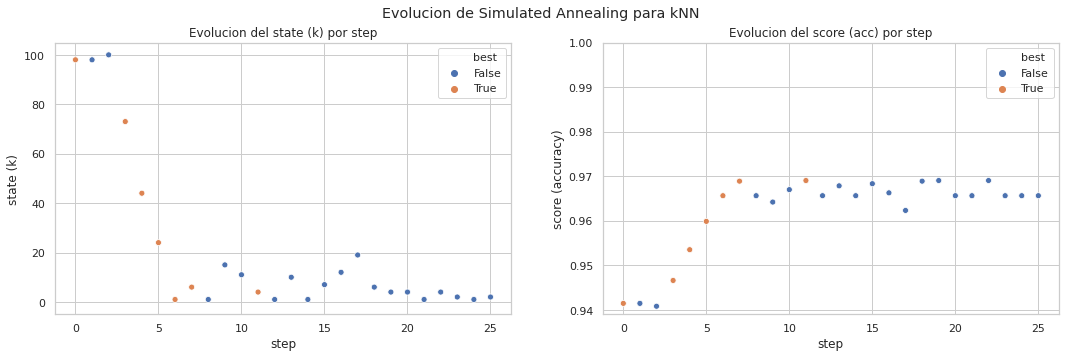

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
k_range = (-5, 105)

sns.set(style="whitegrid")
fig, (ax_state, ax_score) = plt.subplots(1, 2, figsize=(18, 5))
ax_score.set_ylim(0.939, 1)
ax_state.set_ylim(k_range)
state = sns.scatterplot(data=df, x="step", y="state", ax=ax_state, hue="best")
state.set_title("Evolucion del state (k) por step")
state.set(ylabel="state (k)")

score = sns.scatterplot(data=df, x="step", y="score", ax=ax_score, hue="best")
score.set_title("Evolucion del score (acc) por step")
score.set(ylabel="score (accuracy)")

fig.suptitle("Evolucion de Simulated Annealing para kNN")

In [48]:
# Sacamos los duplicados porque ciertos states se recorren mas de una vez
df_unique = df.drop_duplicates(subset=["state", "score"])
df_unique.sort_values("score", ascending=False)
#df_unique.to_csv("data/knn/optimization/results_unique.csv", index=False)

Text(0.5, 0.98, 'State (k) contrastado con score (accuracy) para kNN en Simulated Annealing')

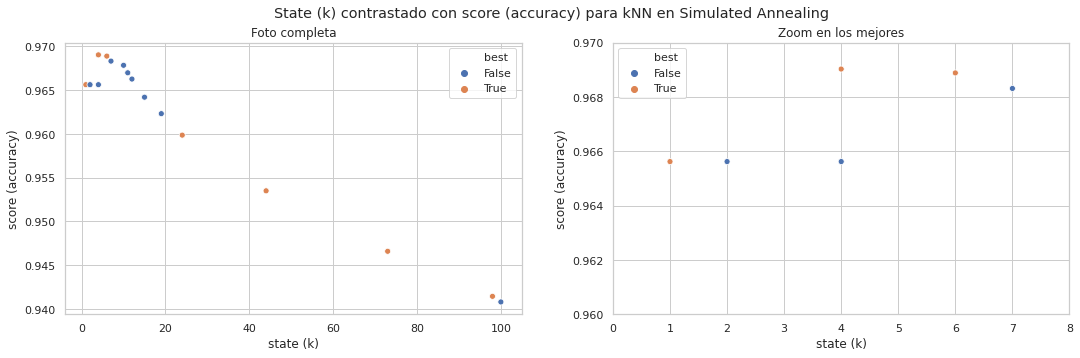

In [49]:
import seaborn as sns
sns.set(style="whitegrid")

fig, (ax, ax_zoom) = plt.subplots(1, 2, figsize=(18, 5))
plot = sns.scatterplot(
    data=df_unique, x="state", y="score", 
    hue="best",
    ax=ax,
)
plot.set(ylabel="score (accuracy)", xlabel="state (k)")
plot.set_title("Foto completa")

# zoom
zoom = sns.scatterplot(
    data=df_unique, x="state", y="score", 
    hue="best",
    ax=ax_zoom,
)
ax_zoom.set_xlim(0, 8)
ax_zoom.set_ylim(0.96, 0.97)
zoom.set(ylabel="score (accuracy)", xlabel="state (k)")
zoom.set_title("Zoom en los mejores")
fig.suptitle("State (k) contrastado con score (accuracy) para kNN en Simulated Annealing")
